##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [74]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from torch.nn import BatchNorm1d, Module, ReLU, Linear, MSELoss, CrossEntropyLoss, Sequential, NLLLoss
np.set_printoptions(threshold=sys.maxsize)

In [75]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [76]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
print(df['DayOfWeek'])
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

0         Friday
1       Thursday
2        Tuesday
3       Thursday
4       Thursday
         ...    
270       Monday
271       Monday
272     Thursday
273    Wednesday
274    Wednesday
Name: DayOfWeek, Length: 275, dtype: object


In [77]:
#try to run this cell only once or else var unique_days will be messed up
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
#took the index of unique for the days;used for the analysis of task 6
#if unique_days not giving string of the days but instead indexes, need to reread the data (run previous cells again)
df['DayOfWeek'], unique_days = pd.factorize(df['DayOfWeek'])
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount, unique_people = pd.factorize(df['VictimCount']) 
df.NIBRSOffenseCode, area = pd.factorize(df['NIBRSOffenseCode'])
df.dropna(inplace=True)

In [78]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [82]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [7]:
df["DayOfWeek"]


0      0
1      1
2      2
3      1
4      1
      ..
270    5
271    5
272    1
273    6
274    6
Name: DayOfWeek, Length: 275, dtype: int64

In [8]:
#Task 1
#few row of the values:
print("\nHead:")
print(df.head())
print("\nTail:")
print(df.tail())


Head:
            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  

Tail:
              X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
270 -115.114739  36.119592             5                 1          5    18   
271 -115.080764  36.162648             0                 1          5    17   
272 -115.172073  36.123012             4                 1          1    16   
273 -115.152593  36.066073             5                 1          6    23   
274 -115.060345  36.137296

In [9]:
#Explain Columns of Data:
#Looking at mainly the head and tail of the list:
#The longitude and latitude (X and Y) seem to appear in similar areas with X roaming around -115 and Y roaming around 36. The main difference seem to
#vary here in the decimals

#Area_Command, NIBRSOFFENSECODE, DayOfWeek, Time, and VictimCount are factorized, meaning that the values are based of uniqueness 
#from the first few data sets rather  than being actual values. Hence the larger the values in the column appear means 
#that the actual values are more distinct/the dataset does not reside in common values.

#Area_Command looks to appear to have multiple unique values compare to the rest (just based on head and tail rows) with the head starting off with 
#multiple unique values. Also in the tails for Area_Command, a 9 appears, showing that there is atleast 9 unique values. This seems interesting 
#as the physical location of X and Y do not appear to far off from one another in the rows, but already they have unique Area_Command; this may show
#a hint about how this column may have a greater factor than the other columns consider (just an initial prediction).

#NIBRSOFFENSECODE, unlike Area_Command appear to have very few unique values, with 0 just appearing one time and 1 appearing the rest. Unlike 
#Area_Command, I predict that this column will have a lower factor towards deciding the target than Area_Command

#DayOfWeek appears to have a similar uniqueness rate as Area_Command but possibly little less as it is not confirmed that it goes to 9 like in 
#Area_Command. This however may just be the case for the head and tail of the df and not the whole picture.

#Time appears to have the most uniqueness rate out of all the other columns, which goes up to atleast 23. This does make sense though as 23 is right 
#below 24 and there are 24 hours in general. This suggests that this dataset may cover all hours from 12 am to 12 pm. Sidenote 1 hour could be possibly
#missing since only 23 is guarenteed from the tails

#VictimCount appears to have little uniqueness rate being only slightly more than NIBRSOffenseCode. Looking back at the actual numbers for VictimCount 
#and knowing that there is small uniqueness, this suggests that people are generally not going on large murder sprees frequently. Killing of 1 or 2 
#people seem to be common and possibly make sense sociologically as murderers generally target only 1 person because of personal issues and revenge or
#some accident; people do not do random murder sprees where they just felt like killing an insane amount. Large murders would also have more unique
#range, which is not seen here in this dataset based on heads and tails.

#conclusion: should normalize the data by column as the ranges for all the columns
#differ. Will use batch normalization to normalize by the mean rather than min-max norm as outliers has been shown to occur for a few of the features.

#input: X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time, VictimCount
#target: number of persons involved in the accident

In [10]:
#Range:
print("Details:")
print(df.describe())

Details:
                X           Y  Area_Command  NIBRSOffenseCode   DayOfWeek  \
count  275.000000  275.000000    275.000000        275.000000  275.000000   
mean  -115.159326   36.143360      3.978182          0.909091    2.981818   
std      0.101294    0.118418      3.045799          0.334878    1.924590   
min   -116.000000   35.068419      0.000000          0.000000    0.000000   
25%   -115.209198   36.114704      1.000000          1.000000    1.000000   
50%   -115.149945   36.152415      3.000000          1.000000    3.000000   
75%   -115.105200   36.183854      6.000000          1.000000    5.000000   
max   -114.625570   37.000000     11.000000          2.000000    6.000000   

             Time  VictimCount  
count  275.000000   275.000000  
mean    11.236364     0.712727  
std      7.039937     0.978427  
min      0.000000     0.000000  
25%      5.000000     0.000000  
50%     11.000000     0.000000  
75%     18.000000     1.000000  
max     23.000000     6.000000  


## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [11]:
#275 is divisible to a whole number by 25, hence why 25 is chosen as batch_size
batch_size = 25
#training accounts for first 225 batches, testing accounts for last 50 batches
training_input = torch.from_numpy(df.values[0:-50,:-1]).float()
training_label = torch.from_numpy(df.values[0:-50,-1]).float()

testing_input = torch.from_numpy(df.values[-50:,:-1]).float()
testing_label = torch.from_numpy(df.values[-50:,-1]).float()
ones = torch.ones(testing_input.shape[0],1)

#reshape labels from 1d to 2d array for BatchNorm1d 
training_label = training_label.reshape(training_label.shape[0],1)
testing_label = testing_label.reshape(testing_label.shape[0],1)
np.set_printoptions(suppress=True)
torch.set_printoptions(threshold=0)
#batch normalize the data outside the dataset; alternative is to do inside the dataset
m = BatchNorm1d(training_input.shape[1])
n = BatchNorm1d(1)
#chose to normalize both training and testing after the split rather than before (split is when dataset splits into training and testing datasets).
#this is intended to avoid overfitting by having training not consider values shown into testing; case where the model gets an advantage/adjustment over
#the testing dataset even though realistically future dataset is not known to be adjusted to.
norm_training_input = m(training_input)
norm_training_label = n(training_label)
norm_testing_input = m(testing_input)
norm_testing_label = n(testing_label)
print(norm_training_input[:,1])


tensor([ 0.5701,  0.3567,  0.2906,  ...,  0.0121, -0.4857, -0.0214],
       grad_fn=<SelectBackward0>)


In [12]:
#make the custom dataset
class CrimeDataset(Dataset):
    #does not do transform; should do transform next time
    def __init__(self, input, label):
        self.input = input
        self.label = label
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        input = self.input[idx]
        label = self.label[idx]
        return input, label

        

In [13]:
#creating dataloaders for the training and testing models
training_set = CrimeDataset(norm_training_input, norm_training_label)
training_set = DataLoader(training_set, batch_size=batch_size)
testing_set = CrimeDataset(norm_testing_input, norm_testing_label)
testing_set = DataLoader(testing_set, batch_size=batch_size)

In [14]:
#verify shapes for both training and testing model
print("Checking the shape of training_model:\n")
for i,j  in training_set:
    print("Input:")
    print(i.shape)
    print("Label:")
    print(j.shape)

Checking the shape of training_model:

Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])


In [15]:
print("Checking the shape of testing_model:\n")
for i,j  in training_set:
    print("Input:")
    print(i.shape)
    print("Label:")
    print(j.shape)

Checking the shape of testing_model:

Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])
Input:
torch.Size([25, 6])
Label:
torch.Size([25, 1])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [16]:
#the predicted output size should be the same size as the actual y/model will predict 1 value
#for every batch row
class RegressionModel(Module):
    #will use only 1 linear layer with the expectation that a linear regression is not a complicated enough
    #function to require more than 1 layer
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.linear = Linear(6, 1)
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred
        
def model_train_regress(loader, model, loss_fn, optimizer):
    size = len(loader.dataset)
    model.train()
    for batch, (X,y) in enumerate(loader):
        pred = model(X).float()
        loss = loss_fn(pred, y.float())
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        loss, current = loss.item(), (batch + 1) * len(X)
        #loss for each batch
        print(f"MSE loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def model_test_regress(loader, model, loss_fn, y_mean, y_std):
    #y_mean and y_std is used to inverse the normalize done for y
    #the prediction removes the normalization and converts to actual predicted number of total people involved
    #it is possible that some values may be loss (with negative values being generalized and rounding)
    model.eval()
    size = len(loader.dataset)
    num_batches = len(loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in loader:
            #commented out code checks pred and y loss and accuracy if it were denormalized (predicted number); some values get loss here if used
            #pred = (model(X)*y_std+y_mean).round()
            #pred[pred<0] = 0
            #y = (y*y_std+y_mean).round()
            #y[y<0] = 0
            pred = model(X)
            pred = (pred*y_std+y_mean).round()
            y_new = y
            y_new = (y_new*y_std+y_mean).round()
            pred[pred<0] = 0
            y[y<0] = 0
            test_loss += loss_fn(model(X),y).item()
            correct += (pred == y_new).float().sum()
            
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {100*correct:>0.1f}%, Avg MSE loss: {test_loss:>8f} \n")
        #print(f"Test Error: \n Avg MSE loss: {test_loss:>8f} \n")




In [17]:
#hyperparameters report
#model stagnates around epoch 7 so any more of 7 seem to be pointless. epoch 15 is just to see for potential outlier
epoch = 15
#1e-1 seems to give the lowest consistent MSE error. 1e-2 also comes close as the second lowest. 1 and higher seems to be unreliable and along with 
#1e-4
learning_rate = 1e-1




regressModel = RegressionModel()
loss_fn_MSE = MSELoss()
#Loss_fn_MSE = CrossEntropyLoss()
optimizer_regress = torch.optim.SGD(regressModel.parameters(), lr=learning_rate)

In [18]:
y_mean_testing = testing_label.mean()
y_std_testing = testing_label.std()
print("Testing set before Trained Model:\n")
model_test_regress(testing_set,regressModel, loss_fn_MSE,y_mean_testing, y_std_testing)

Testing set before Trained Model:

Test Error: 
 Accuracy: 48.0%, Avg MSE loss: 1.391029 



In [19]:
#training
regressModel = RegressionModel()
loss_fn_MSE = MSELoss()
optimizer_regress = torch.optim.Adam(regressModel.parameters(), lr=learning_rate)
y_mean_training = training_label.mean()
y_std_training = training_label.std()
print("Training. Printing the loss for each batch (loss slowly decreases by each enoch for each batch):\n")
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    model_train_regress(training_set, regressModel, loss_fn_MSE, optimizer_regress)
    model_test_regress(training_set, regressModel, loss_fn_MSE, y_mean_training, y_std_training)

Training. Printing the loss for each batch (loss slowly decreases by each enoch for each batch):

Epoch 1
-------------------------------
MSE loss: 0.705426  [   25/  225]
MSE loss: 0.726206  [   50/  225]
MSE loss: 0.681002  [   75/  225]
MSE loss: 0.403715  [  100/  225]
MSE loss: 1.137668  [  125/  225]
MSE loss: 1.646970  [  150/  225]
MSE loss: 1.080604  [  175/  225]
MSE loss: 1.907759  [  200/  225]
MSE loss: 2.700341  [  225/  225]
Test Error: 
 Accuracy: 47.6%, Avg MSE loss: 0.846307 

Epoch 2
-------------------------------
MSE loss: 0.544378  [   25/  225]
MSE loss: 0.367576  [   50/  225]
MSE loss: 0.775950  [   75/  225]
MSE loss: 0.541695  [  100/  225]
MSE loss: 0.953219  [  125/  225]
MSE loss: 1.635067  [  150/  225]
MSE loss: 1.021165  [  175/  225]
MSE loss: 1.160865  [  200/  225]
MSE loss: 2.127523  [  225/  225]
Test Error: 
 Accuracy: 41.8%, Avg MSE loss: 0.673826 

Epoch 3
-------------------------------
MSE loss: 0.565327  [   25/  225]
MSE loss: 0.350237  [   

In [20]:
y_mean_testing = testing_label.mean()
y_std_testing = testing_label.mean()
print("Testing set after Trained Model:\n")
model_test_regress(testing_set, regressModel, loss_fn_MSE, y_mean_testing, y_std_testing)

Testing set after Trained Model:

Test Error: 
 Accuracy: 42.0%, Avg MSE loss: 0.819287 



In [21]:
#summary: The regression model trained ok initially but quickly stagnates around epoch 7. The Avg MSE loss does get generally better at predicting 
#the test set (if prediction was based off MSE loss) after training the regression model. Also during the training, the accuracy appears to go down 
#initially sometimes, but this may just be due to initial weight rounding better when denormalizing. The MSE loss does go down still despite decreasing
#accuracy implying that the model is training.


## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [22]:
#to get the number of classes, I can get the range of the actual output data and have that range be the classes
#if the range is not too large

#checking the range
print(training_label.max())
print(training_label.min())
print()
print(testing_label.max())
print(testing_label.min())

tensor(4.)
tensor(0.)

tensor(6.)
tensor(0.)


In [23]:
#since the range is not too large (0:4 or 0:6), I can use this as for the number of classes
#using only the range of the training_label (since testing acts as being unpredicatable), I can have classes be from 0:4 with an/some extra class(es) 
#acting for outliers if the predicted value is even higher than the expected max. Like in this case, 4 is expected max but testing label has 6 as the 
#max/unconsidered clas
#for this test, the outlier class will be to double the expected max to handle outliers (from 0:4 to 0:8).
#also note that outliers for the minimum is not considered as having negative people on the scene is unrealistic.

In [24]:
class ClassificationModel(Module):
    #this function is more complicated than the RegressionModel; more layers will be used
    #will use 3 layers with arbitrary hidden nodes value as an arbitrary start
    #output between a classification of range 0:8
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = Sequential(
            Linear(6, 7),
            ReLU(),
            Linear(7, 7),
            #ReLU(),
            Linear(7,8))
    def forward(self, x):
        y_pred = self.linear_relu_stack(x)
        return y_pred

def model_train_classify(loader, model, loss_fn, optimizer, y_mean, y_std):
    #y_mean and y_std to denormalize y. not used in regression model_train
    size = len(loader.dataset)
    model.train()
    for batch, (X,y) in enumerate(loader):
        #argmax(1) gets the predicted/highest class of each batch
        pred = model(X).float()
        #denormalize y
        y = (y*y_std+y_mean).round()
        y[y<0] = 0
        #flatten to fit description of target of cross entropy loss
        y = y.flatten().long()
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        loss, current = loss.item(), (batch + 1) * len(X)
        #loss for each batch
        #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def model_test_classify(loader, model, loss_fn, y_mean, y_std):
    #y_mean and y_std to denormalize y
    model.eval()
    size = len(loader.dataset)
    num_batches = len(loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in loader:
            pred = model(X).argmax(1).reshape((25,1)).float()
            y = (y*y_std+y_mean).round()
            y[y<0] = 0
            correct += (pred == y).float().sum()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {100*correct:>0.1f}%")


In [25]:
#run this before training
#hyperparameters report
#around 550 does the max seem to stagnate
epoch = 550
#learning_rate 1e-3 appears to give the greatest accuracy without overfitting. learning_rate 1e-2 actually gives the highest accuracy for the training
#set but in the testing set, it gives less accuracy than 1e-3. 1e-3 gives a consistent value around 45 but 1e-2 goes lower in the testing set.
learning_rate = 1e-3

classifyModel = ClassificationModel()
#main difference between CrossEntropyLoss and MSE is that CrossEntropyLoss is nonlinear and MSE is linear. This is due to some use of some activation 
#function (ReLU) that generalizes values to turn on or off to distinguish between classes. The use of the activation function in the model makes 
#CrossEntropyLoss more ideal. The loss function will now require input be the probabilities of all the classes for all batches and y will be flatten
#for the sake of the intended shape to be taken by the function.
loss_fn_cross = CrossEntropyLoss()
optimizer_classify = torch.optim.Adam(classifyModel.parameters(), lr=learning_rate)

In [26]:
y_mean_testing = testing_label.mean()
y_std_testing = testing_label.std()
print("Testing set before Trained Model:\n")
model_test_classify(testing_set, classifyModel, loss_fn_cross, y_mean_testing, y_std_testing)

Testing set before Trained Model:

Test Error: 
 Accuracy: 6.0%


In [27]:
#training


y_mean_training = training_label.mean()
y_std_training = training_label.std()
print("Training. Printing the loss for each batch (loss slowly decreases by each enoch for each batch):\n")

for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    model_train_classify(training_set, classifyModel, loss_fn_cross, optimizer_classify,y_mean_training, y_std_training)
    model_test_classify(training_set, classifyModel, loss_fn_cross, y_mean_training, y_std_training)

Training. Printing the loss for each batch (loss slowly decreases by each enoch for each batch):

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 0.4%
Epoch 2
-------------------------------
Test Error: 
 Accuracy: 0.4%
Epoch 3
-------------------------------
Test Error: 
 Accuracy: 1.3%
Epoch 4
-------------------------------
Test Error: 
 Accuracy: 28.0%
Epoch 5
-------------------------------
Test Error: 
 Accuracy: 36.4%
Epoch 6
-------------------------------
Test Error: 
 Accuracy: 40.0%
Epoch 7
-------------------------------
Test Error: 
 Accuracy: 44.4%
Epoch 8
-------------------------------
Test Error: 
 Accuracy: 48.9%
Epoch 9
-------------------------------
Test Error: 
 Accuracy: 50.7%
Epoch 10
-------------------------------
Test Error: 
 Accuracy: 51.1%
Epoch 11
-------------------------------
Test Error: 
 Accuracy: 50.2%
Epoch 12
-------------------------------
Test Error: 
 Accuracy: 50.2%
Epoch 13
-------------------------------
Test Error: 
 Accurac

In [28]:
print("Testing set after Trained Model:\n")
model_test_classify(testing_set, classifyModel, loss_fn_cross,y_mean_testing,y_std_testing)

Testing set after Trained Model:

Test Error: 
 Accuracy: 46.0%


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

In [29]:
#ensure that the regress and classify model are trained first
print("Trained Regression Model on Testing set:")
model_test_regress(testing_set, regressModel, loss_fn_MSE, y_mean_testing, y_std_testing)
print("Trained Classify Model on Testing set:")
model_test_classify(testing_set, classifyModel, loss_fn_cross,y_mean_testing,y_std_testing)

Trained Regression Model on Testing set:
Test Error: 
 Accuracy: 46.0%, Avg MSE loss: 0.819287 

Trained Classify Model on Testing set:
Test Error: 
 Accuracy: 46.0%


In [30]:
#To compare results of the models, I get the prediction of both trained model and denormalize them and compare with the actual labels (that are also 
#denormalize). After trying the above cells a couple times (All the cells to recreate and train the regress and classify models), it appears that 
#the regression model consistently gets 46% accuracy while the classify model can get between 42% and 50% accuracy. Because one model appears consistent
#(but not by much) and the other has more upside but less consistent, the discussion of which is better seems to be by situation. I am not sure which 
#model worked better but the classify model was capable of handling more epoch than the regress model which stagnated very early. Having the model 
#stagnate so quick could be a sign of a flaw in my regression model; the classify model acted more as expected for how training should be.


In [31]:
def find_one_miss_classification(loader, model, y_mean, y_std):
    '''finds a single miss classification and creates a bar graph showing the probabilities of its classes'''
    model.eval()
    for X, y in loader:
        pred = model(X)
        pred_max = pred.argmax(1).reshape((25,1)).float()
        y_denorm = y
        y_denorm = (y_denorm*y_std+y_mean).round()
        y_denorm[y_denorm < 0] = 0
        for i in range(0, len(pred)):
            if not (pred_max[i] == y_denorm[i]):
                #abs() as sometimes denormalization converts to -0 instead of 0. Use of abs should not affect class names as its all positive/no 
                #negative anyway
                print(f"Predicted: {pred_max[i].item()}, Actual: {abs(y_denorm[i].item())}")
                #convert logit to prob with softmax
                prob = torch.softmax(pred[i], dim=0) * 100
                plt.xlabel("Class")
                plt.ylabel("Likelihood")
                bar = plt.bar([i for i in range(8)],prob.detach())
                #return as job is already done
                return

Predicted: 0.0, Actual: 1.0


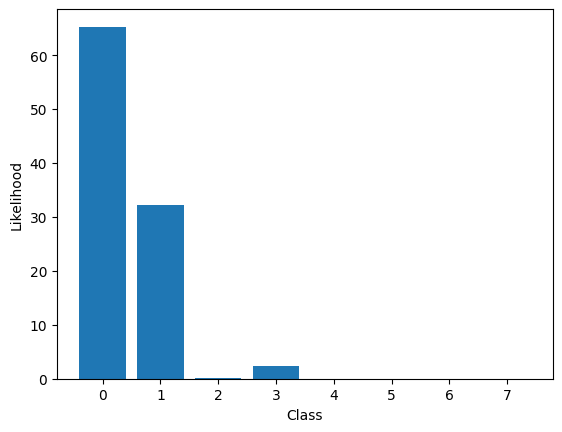

In [32]:
find_one_miss_classification(testing_set, classifyModel, y_mean_testing, y_std_testing)

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the coordinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


Index(['Friday', 'Thursday', 'Tuesday', 'Saturday', 'Sunday', 'Monday',
       'Wednesday'],
      dtype='object')


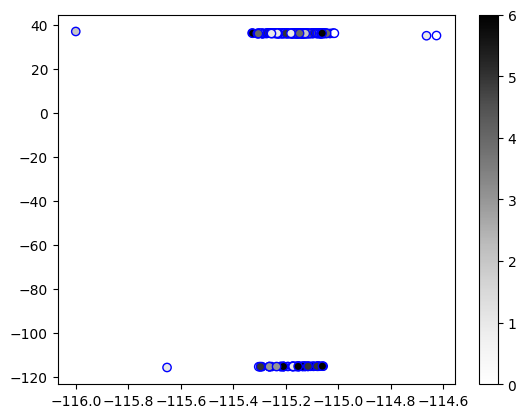

In [69]:
coordinate_x = torch.tensor(training_input[:,0].tolist() + testing_input[:,0].tolist())
coordinate_y = torch.tensor(training_input[:,1].tolist() + testing_input[:,0].tolist())
day = torch.tensor(training_input[:,4].tolist() + testing_input[:,4].tolist())
plt.scatter(coordinate_x,coordinate_y, c=day, cmap="Greys", edgecolor="blue")
plt.colorbar()
#unique_days is initalized when making the original df (took from pd.factorize on days of week)
print(unique_days)
plt.show()

In [71]:
#^^^
#There appears to be a pattern of location on the scatter space. Many of the values are scattered close together, with two distinct area located at the
#top and bottom. This implies that these certain areas tend to have plenty of problems/incidents. In these spaces, there appears to be days of all 
#type that are involved in these location. However, based on the cmap, days represented to be darker seem to appear most often, especially on the bottom
#space. Since the factorize days are not ordered in a meaningful manner (Monday, Tuesday, Wednesday, etc.), I need to look at the actual days
#corresponding to the indexes rather than rely on the color tone and the scale of it. This means that Wednesday, Monday, Sunday, and Saturday appear
#to be days where incident tend to happen being that those day are dark. This is however mainly a general guess. What I can observe about any patterns
#of the days are from the few outliers appearing outside the two main spaces. These outliers tend to be of lighter color, which contrasts the other half
#of the days (the darker colors) by being common outside the main spaces. In other words, it is ironic that the darker colors (using colors just to 
#efer to the one half of the days set) are not too common in the outliers despite appearing dominant in the main spaces.

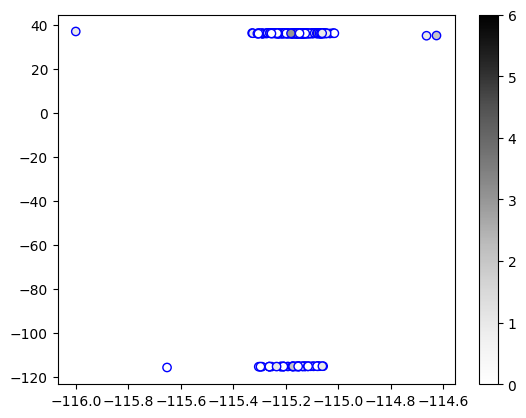

In [89]:
#number of people involve after factor (factorize heavily simplies how many people involve by distinguishing only unique values and not the actual
#how many people involve)
people = torch.tensor(training_label[:,0].tolist() + testing_label[:,0].tolist())
plt.scatter(coordinate_x,coordinate_y, c=people, cmap="Greys", edgecolor="blue")
plt.colorbar()

In [90]:
#^^^
#Looking at the actual colors, being that this time the color scale matters (unlike the days if not including the use to distinguish half of the set)
#and understanding that there is 2 main common spaces of incidents (top and bottom), it appears that many incident are very common to the lighter side
#of the classification for how many people is involve. Despite the var people being factorize, many of the lighter/lower colors do have a correspondance
#with how frequent certain numbers of people are involved. This meaning that the lighter colors are also low in value for how many people are involved.
#0 is both the lightest color determined by the factorization, the most common incident number in the actual set, and the lowest casualty realistically
#As stated before when talking about VictimCount, 0 or 1 or 2 people could be implied to be of accidents or small incident and higher values of like 10
#implies of murder sprees. With these distinction, accident or small incident can intuitive be understood to occur less than murder sprees.
#Understanding this about the lighter colors, it makes sense in the plot that one common pattern is that many of the incidents tends to be of the 
#lighter side. In contrast of this, the darkest color, 6, is/are barely visible from a general look, further emphasizing the rarity of a high people
#count incident. What could also be pointed are in the outliers. It may be a little suprising that the outliers on the top have no 0/white colors, 
#despite white being very dominant. These areas on the top outliers may tell a story that despite not living in an area full of incidents (which may be
#judged as dangerous) is still not as peaceful as initially presume, being that people still got hurt. There is one outlier at the bottom which is 0,
#which implies the initial judgement of the top outlier but true (or not yet proven false).

In [144]:
#get the statistic of the days with the highest incident 
#counts all the incidents occuring on each day
count, unique = np.unique(day, return_counts=True)
temp_count = dict(zip(count,unique))
temp_count = sorted(temp_count.items())
#replace factorize index of days to the actual days to visualize easier
day_count = {}
for i in range(len(temp_count)):
    day_count[unique_days[i]] = temp_count[i][1]
day_count = sorted(day_count.items(),key = lambda day_count:day_count[1], reverse=True)
#sorted by days with the highest incidents count first
print(day_count)


    

[('Sunday', 51), ('Saturday', 44), ('Monday', 43), ('Friday', 40), ('Thursday', 37), ('Tuesday', 32), ('Wednesday', 28)]


In [ ]:
#It appears that Sunday is the day with the most frequent incident count. There is some jump from Sunday to Saturday (Saturday is the second highest) 
#with a jump of 7. This is the highest of any jump between two days, implying that Sunday is a special/more common day for incidents to happen.
#I can also note that it is possible that the classification model may have found this pattern of Sunday being frequent during training.
#I can also reflect that for the analysis of the first bar graph (about the days), I mention that the darker day, which I will now group as 
#the last 4 indexes of the color bar or the unique days as seen below, had appear to be most common on the bar graph. Looking at the actual statistics,
#I can now see that this pattern is correct except for Wednesday, which actually has the lowest frequency. I can maybe use this insight on the 
#convolutional neural network, which can pick up patterns both good and bad. I feel that this is a potential example of a nn picking up a potentially 
#bad pattern for classification by judging darker values (which in the context of nn, I will replace darker values as the higher and lower index as 
#numbered index scale can be seen in nn and still corresponds with darker and lighter colors of the cmap) as being days with more incidents. Even if it 
#is true for the other darker values, it is not true for Wednesday. This thought may be of a stretch since I do not bring up/fully understand the 
#actual connection between the mathematical equations the nn use to pick up patterns and this thought of judging darker values

In [145]:
print(unique_days)

Index(['Friday', 'Thursday', 'Tuesday', 'Saturday', 'Sunday', 'Monday',
       'Wednesday'],
      dtype='object')
